The RT60 is 82 ms
(6, 201674)
(257, 787, 6)


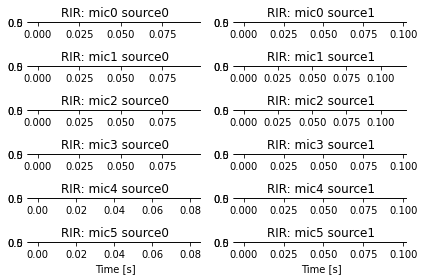

In [1]:
import numpy as np
import librosa
from scipy.fftpack import fft
import matplotlib.pyplot as plt
from DistantSpeech.transform.transform import Transform
from DistantSpeech.beamformer.utils import pmesh, mesh, load_wav, save_audio, load_pcm, visual, pt
from DistantSpeech.beamformer.utils import load_audio as audioread
from DistantSpeech.beamformer.utils import save_audio as audiowrite
from DistantSpeech.beamformer.MicArray import MicArray, ArraySim
from DistantSpeech.beamformer.beamformer import beamformer, steering, compute_mvdr_weight, get_gev_vector, phase_correction, blind_analytic_normalization
from DistantSpeech.beamformer.MicArray import MicArray, compute_tau
from DistantSpeech.noise_estimation.mcspp import McSpp
wavpath = '/home/wangwei/work/Beamforming-for-speech-enhancement-master/sample_data'
array_data, _ = load_wav(wavpath)

mic_angle_vector = [0,60,120,180,240,300]
sampling_frequency = 16000
fft_length = 512
fft_shift = 256
mic_diameter = 0.1
sound_speed = 343
look_direction = 30

signal = audioread("/home/wangwei/work/DistantSpeech/samples/audio_samples/cleanspeech_aishell3_2.wav")
noise = audioread("/home/wangwei/work/DistantSpeech/samples/noise/office1.wav")
fs = 16000
M = 6
mic_array = MicArray(arrayType="circular", r=mic_diameter/2, M=M, n_fft=fft_length)
mic_array_sim = mic_array.array_sim
# print(mic_array_sim.R)
array_data, premix = mic_array_sim.generate_audio(signal, interference=noise, source_angle=look_direction, interf_angle=270, sir=10, snr=30)
# audiowrite('mix.wav', np.transpose(array_data))
# audiowrite('signal.wav', np.transpose(premix[0, :, :]))
# audiowrite('interf.wav', np.transpose(premix[1, :, :]))
print(array_data.shape)
M = array_data.shape[0]
transform = Transform(n_fft=512, hop_length=256, channel=M)
D = transform.stft(np.transpose(array_data))
half_bin = D.shape[0]
frame_num = D.shape[1]
print(D.shape)

### here we domestrate based MVDR beamformer RTF, we compute RTF from TDOA or principle eigenvector

(257, 6, 6)


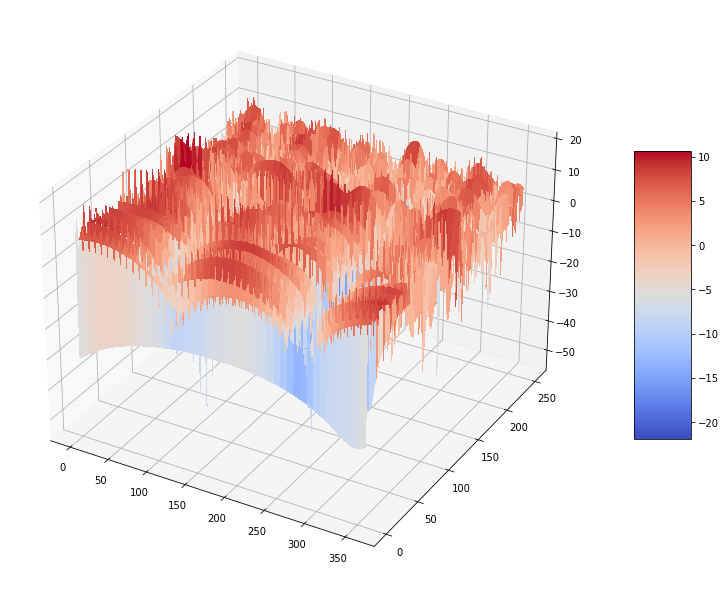

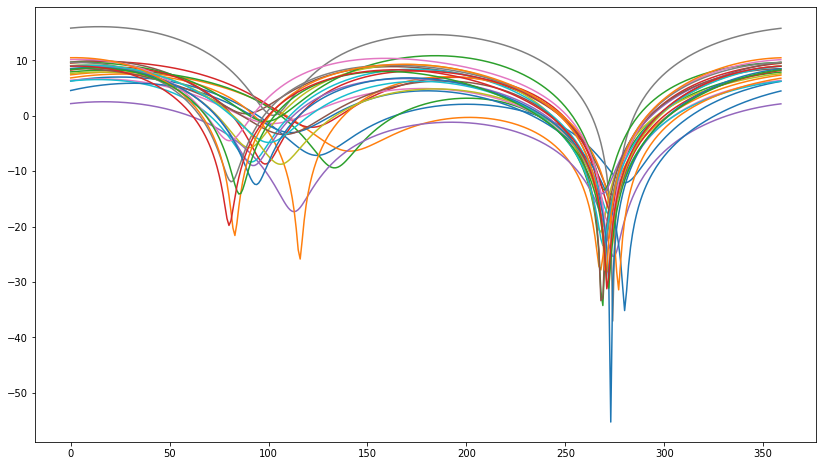

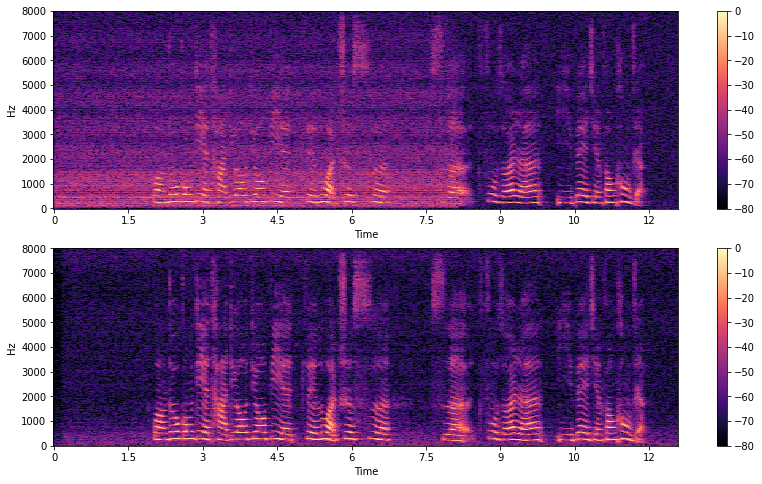

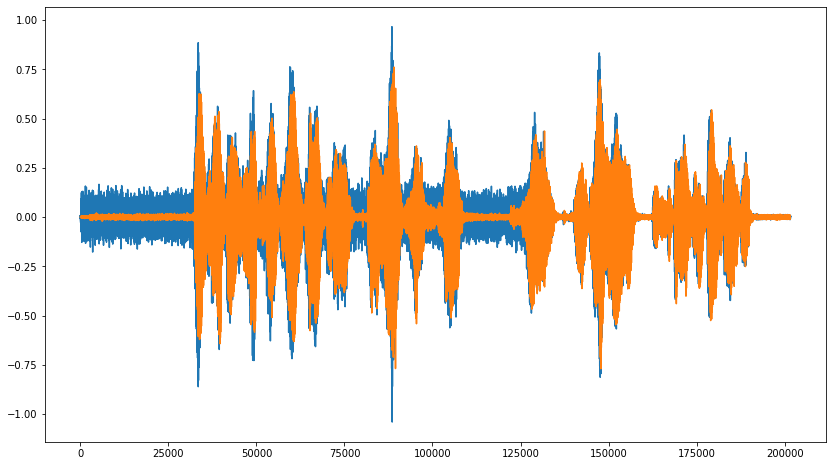

In [2]:
Rvv = np.zeros((half_bin,M,M), dtype=complex)
Ryy = np.zeros((half_bin, M,M), dtype=complex)
Rxx = np.zeros((M,M, half_bin), dtype=complex)
xi = np.zeros((frame_num, half_bin))
Rvv1 = np.zeros((frame_num, half_bin))
Yout = np.zeros((half_bin, frame_num), dtype=complex)

init_frame = 10
for n  in range(init_frame):
    y = D[:, n, :] # [freq, channel]
    psd_yy = np.einsum('ij,il->ijl', y, y.conj()) # [freq, M,M]
    if n == 0:
        print(psd_yy.shape)
    Rvv = Rvv + psd_yy

Rvv = Rvv/init_frame
Rvv_inv = np.linalg.inv(Rvv)

speech_start = 130
speech_stop = 380
speech_frames = (speech_stop - speech_start + 1)
for n  in np.arange(speech_start,speech_stop):
    y = D[:, n, :] # [freq, channel]
    psd_yy = np.einsum('ij,il->ijl', y, y.conj()) # [freq, M,M]
    if n == 0:
        print(psd_yy.shape)
    Ryy = Ryy + psd_yy

Ryy = Ryy/speech_frames

# EVD
steer_vector_from_pca = steering(Ryy-Rvv)

# GEVD
steer_vector_from_gevd = steering(np.linalg.inv(Rvv) @ (Ryy-Rvv))
steer_vector_from_gevd = (Rvv @ steer_vector_from_gevd[..., None]).squeeze()


steer_vector_from_tdoa = mic_array.steering_vector(look_direction=look_direction)

w_n = np.zeros((M, half_bin),dtype=complex)

w_mvdr_tdoa = compute_mvdr_weight(steer_vector_from_tdoa, Rvv_inv)
w_mvdr_pca = compute_mvdr_weight(steer_vector_from_pca, Rvv_inv)


beamformer_obj = beamformer(mic=mic_array, frame_len=512)
beamout = beamformer_obj.compute_beampattern(mic_array, weights=w_mvdr_pca.T) # choose w_mvdr_tdoa or w_mvdr_pca to show beampattern
mesh(beamout[:, 2:-2].T)

plt.figure(figsize=(14, 8))
plt.plot(beamout[:, 8:32])
plt.show()

u = np.zeros((M,1))

Yout = np.einsum('inj,ij->in', D, w_mvdr_tdoa.conj())

yout = transform.istft(Yout)
audiowrite('output_mvdr.wav', yout/np.max(np.abs(yout)))
visual(array_data[0], yout)
pt(array_data[0], yout)

### demostrate online MVDR using mcspp esitmator

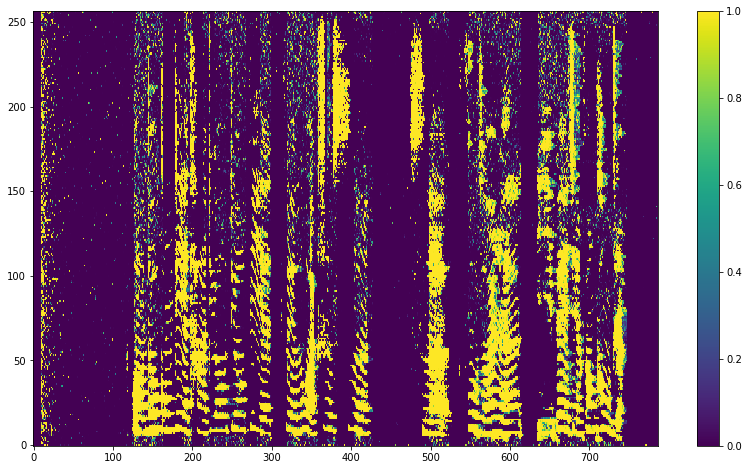

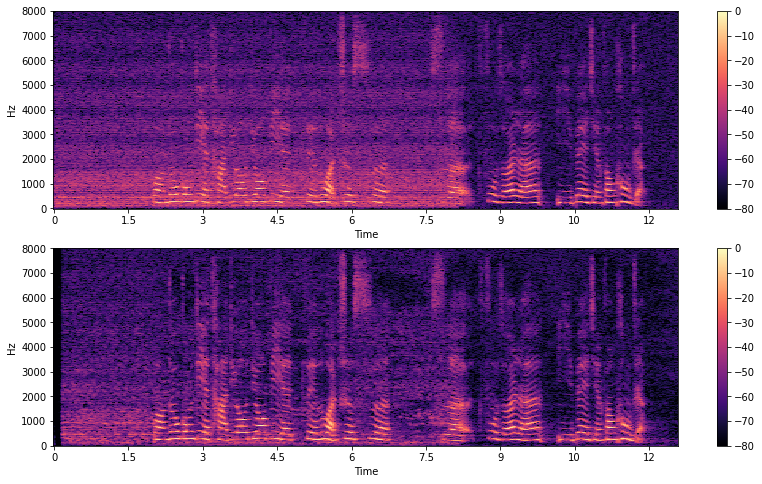

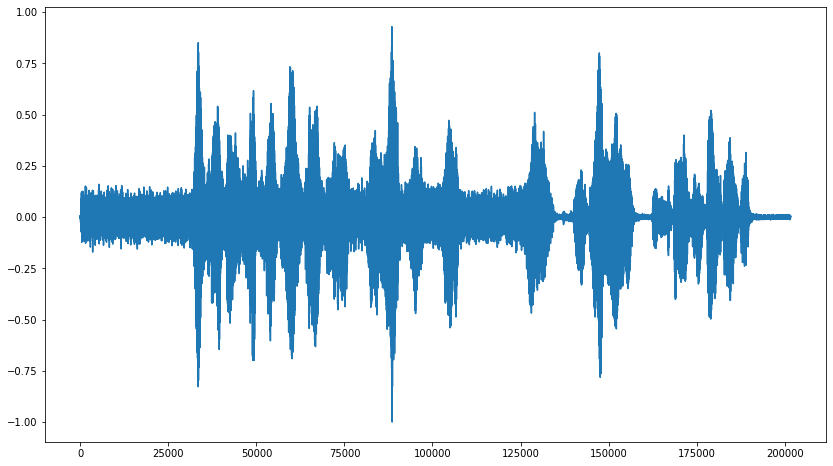

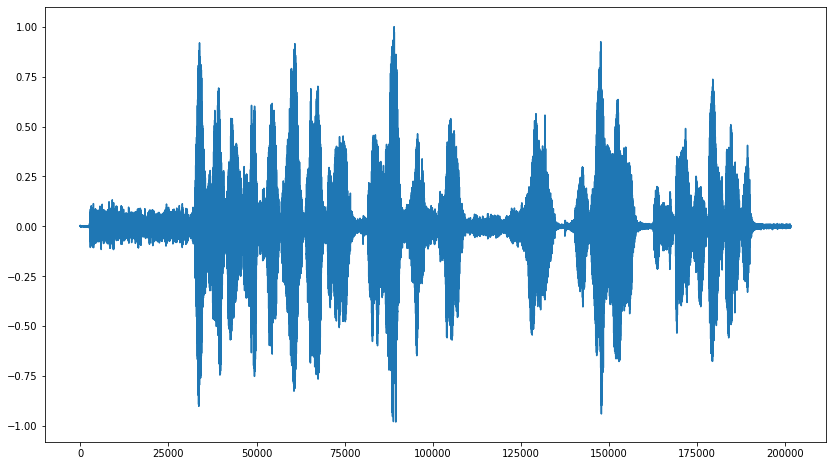

In [3]:
Rvv = np.zeros((half_bin,M,M), dtype=complex)
Ryy = np.zeros((half_bin,M,M), dtype=complex)
Rxx = np.zeros((half_bin,M,M), dtype=complex)
xi = np.zeros((frame_num, half_bin))
Rvv1 = np.zeros((frame_num, half_bin))
Rvv_inv = np.zeros((half_bin,M,M), dtype=complex)

p = np.zeros((half_bin, frame_num))

# online tdoa-based MVDR beamforming
channel = M
noise_estimator = McSpp(nfft=512, channels=channel, mic_array=mic_array)
noise_estimator.mcra.L = 15

alpha_yy = 0.85
alpha_vv = 0.92

diag = np.eye(M) * 1e-6
diag_bin = np.broadcast_to(diag, (half_bin, M, M))

Phi_xx_last = np.zeros((half_bin, M, M), dtype=complex)
Phi_xx_all = np.zeros((half_bin, M, M), dtype=complex)
Phi_vv_all = np.zeros((half_bin, M, M), dtype=complex)

for n in range(frame_num):
    y = D[:, n, :] # [F,M]

    noise_estimator.estimation(y)
    p[:, n] = noise_estimator.p

    steer_vector = steering(noise_estimator.Phi_xx)

    w = compute_mvdr_weight(steer_vector, noise_estimator.Phi_vv_inv)

    Yout[:, n] = np.einsum('ij,ij->i', w.conj(), y)

    if n == 180:
        w_n = (w.T).copy()

pmesh(p)

yout = transform.istft(Yout)
visual(array_data[0], yout)
pt(array_data[0]/np.max(np.abs(array_data[0])))
pt(yout/np.max(np.abs(yout)))

### then we show maske based MVDR beamfomer

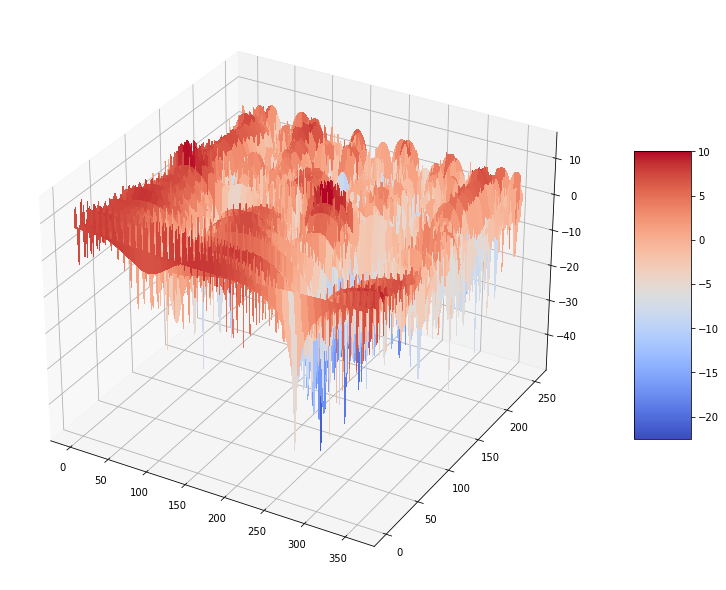

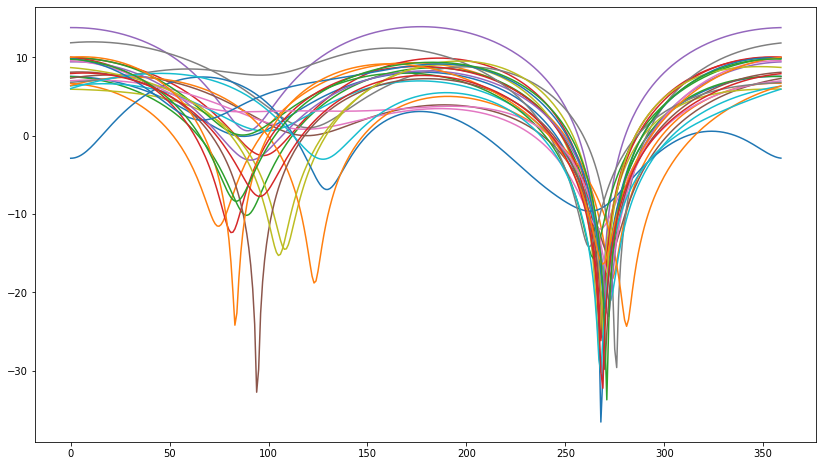

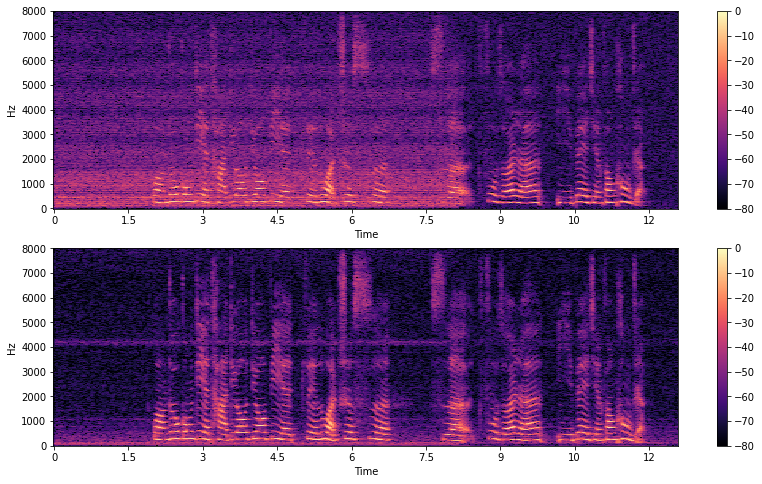

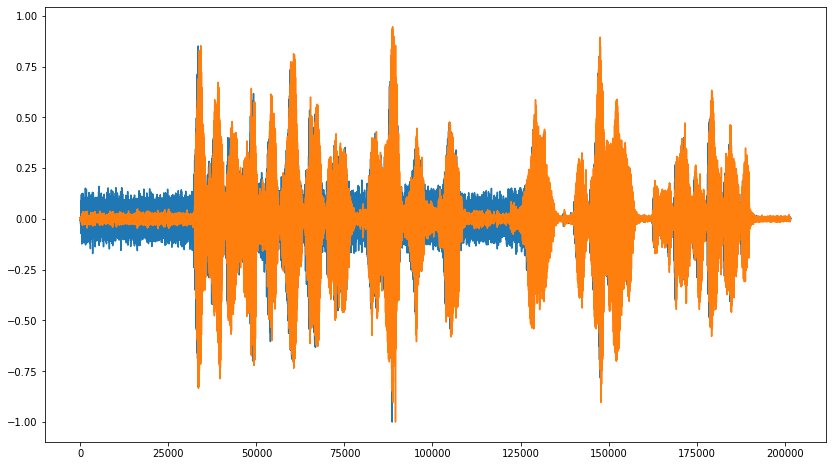

In [4]:
for n in range(frame_num):
    y = D[:, n, :] # [F,M]

    Phi_xx_all = Phi_xx_all + np.einsum('ij,il->ijl', y, y.conj()) * p[:, n:n+1, None]
    Phi_vv_all = Phi_vv_all + np.einsum('ij,il->ijl', y, y.conj()) * (1-p[:, n:n+1, None])

steer_vector = steering(Phi_xx_all)
w = compute_mvdr_weight(steer_vector, np.linalg.inv(Phi_vv_all))
Yout = np.einsum('inj,ij->in', D, w.conj())


beamformer_obj = beamformer(mic=mic_array, frame_len=512)
beamout = beamformer_obj.compute_beampattern(mic_array, weights=w.T)

mesh(beamout[:, 2:-2].T)

plt.figure(figsize=(14, 8))
plt.plot(beamout[:, 8:32])
plt.show()

yout = transform.istft(Yout)
visual(array_data[0], yout)
pt(array_data[0]/np.max(np.abs(array_data[0])), yout/np.max(np.abs(yout)))

### GEVD beamformer

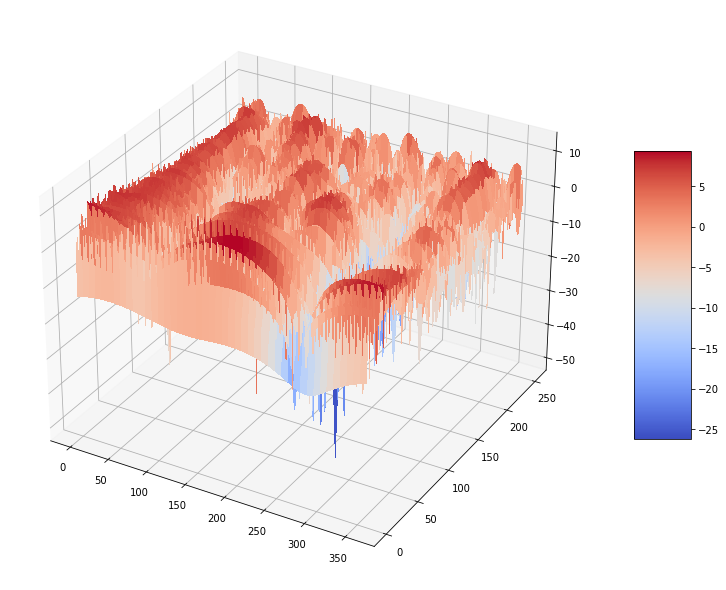

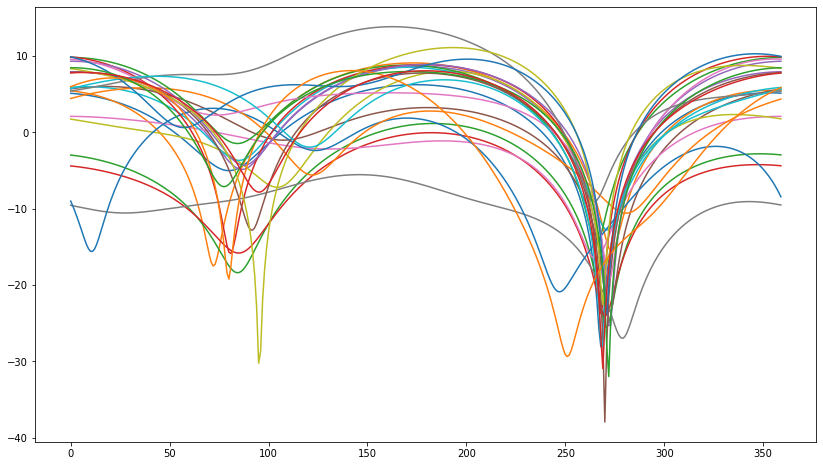

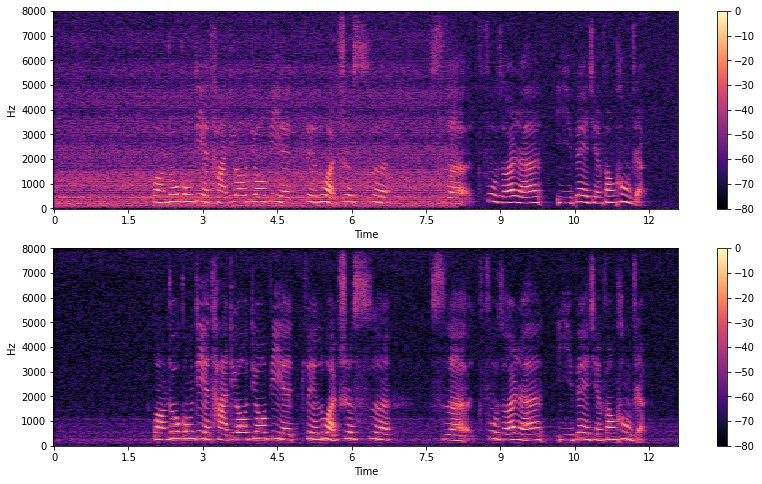

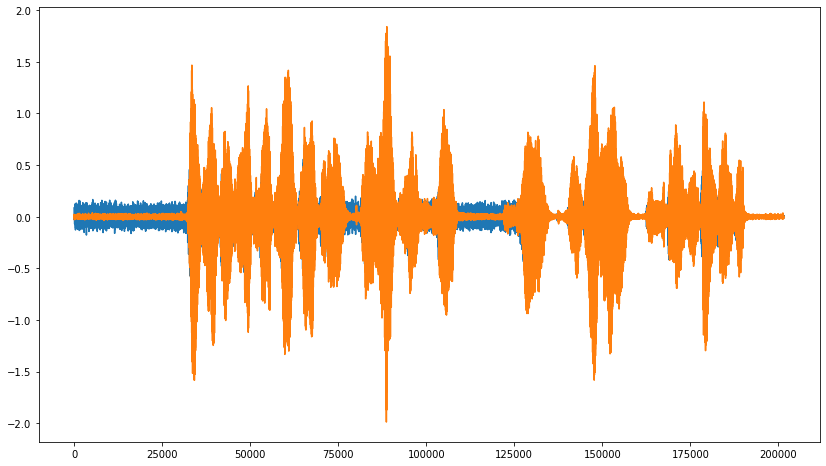

In [5]:

W_gev = get_gev_vector(Phi_xx_all, Phi_vv_all)
W_gev = phase_correction(W_gev)
W_gev = blind_analytic_normalization(W_gev, Phi_vv_all)


Yout = np.einsum('inj,ij->in', D, W_gev.conj())


beamformer_obj = beamformer(mic=mic_array, frame_len=512)
beamout = beamformer_obj.compute_beampattern(mic_array, weights=W_gev.T)
mesh(beamout[:, 2:-2].T)

plt.figure(figsize=(14, 8))
plt.plot(beamout[:, 8:32])
plt.show()

yout_gevd = transform.istft(Yout)
visual(array_data[0], yout_gevd)
pt(array_data[0], yout_gevd)


In [6]:
audiowrite('output_src.wav', array_data[0]/np.max(np.abs(array_data[0])))
audiowrite('output_mvdr_online.wav', yout/np.max(np.abs(yout)))
audiowrite('output_gevd.wav', yout_gevd/np.max(np.abs(yout_gevd)))